#Check the devices available

In [1]:
# !free -h

In [2]:
# !cat /proc/meminfo

In [3]:
# !cat /proc/cpuinfo

In [4]:
# !lscpu |grep 'Model name'

In [5]:
# !lscpu | grep 'Core(s) per socket:'

In [6]:
# !nvidia-smi

In [7]:
# import tensorflow as tf
# tf.config.list_physical_devices()

In [8]:
# from tensorflow.python.client import device_lib
# device_lib.list_local_devices()

In [9]:
# import tensorflow as tf
# tf.test.gpu_device_name()

#Connect to google drive

In [10]:
# from google.colab import drive
# drive.mount('drive')

In [11]:
# cd drive/My\ Drive/Colab\ Notebooks/voice_phishing/DL

In [12]:
# if using local jupyter notebook and not colab
# cd Google Drive/Colab Notebooks/voice_phishing/DL

In [13]:
# %pwd

# Import library

In [14]:
from keras.preprocessing.text import Tokenizer
# from keras.utils import to_categorical
# from keras.models import Sequential
# from keras.layers import Dense, GRU
# from keras.layers import Dropout
# from keras.layers import LSTM
# from keras.callbacks import ModelCheckpoint
# from keras.utils import np_utils
# from keras.layers import Embedding
# from keras.preprocessing.sequence import pad_sequences
# from keras.callbacks import ModelCheckpoint, EarlyStopping
# earlystopping = EarlyStopping(monitor = 'loss', verbose = 1,patience = 8, mode = 'min')
# from keras.layers import Bidirectional, GlobalMaxPool1D
# from keras.callbacks import CSVLogger

from tensorflow.keras.preprocessing.sequence import pad_sequences
# from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Bidirectional, GlobalMaxPool1D
from tensorflow.keras.layers import Dense, Activation, LSTM, Embedding
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K 
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import CSVLogger

import string
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer, WordNetLemmatizer
import nltk
import re

from glob import glob
from tqdm import tqdm

from time import time
from timeit import default_timer as timer
from datetime import timedelta, datetime

import os, re, csv, math, codecs
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math

In [15]:
# from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.feature_extraction import _stop_words
from sklearn.preprocessing import StandardScaler, RobustScaler

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_circles

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

# Import the NPZ file of our dataset

In [16]:
%%time
npsavezFile=np.load("outfile_space_20220414.npz",allow_pickle=True)
print(npsavezFile.files)

vocab=npsavezFile['arr_1']
data=npsavezFile['arr_0']
Y=npsavezFile['arr_2']

Y=list(Y)

['arr_0', 'arr_1', 'arr_2']
CPU times: user 730 ms, sys: 92 ms, total: 821 ms
Wall time: 820 ms


In [17]:
vocab

array(['0', '01', '010', ..., '힙합하는', '힙합하면은', '힝'], dtype='<U23')

In [18]:
# np.set_printoptions(threshold=sys.maxsize)
# data

In [19]:
print(data.dtype)

object


In [20]:
%%time
max_length=max([len(i) for i in data])
#print("max_length",max_length) # max_length 35

#print(sorted([len(i) for i in data]))

CPU times: user 2.63 ms, sys: 0 ns, total: 2.63 ms
Wall time: 2.64 ms


In [21]:
%%time
word_id=dict((c,i) for i,c in enumerate(vocab))
id_word=dict((i,c) for i,c in enumerate(vocab))
#print("word_id",word_id)
#print("id_word",id_word)

CPU times: user 195 ms, sys: 27.9 ms, total: 223 ms
Wall time: 223 ms


In [22]:
%%time
X_train=[]
for sentence in data:
	x=[]
	for word in sentence:
		app=word_id[word]
		x.append(app)
		
	X_train.append(x)
 
#  # Map for readable classnames
# class_names = [0, 1]

CPU times: user 1.06 s, sys: 13.9 ms, total: 1.08 s
Wall time: 1.08 s


In [23]:
%%time
max_length=max([len(i) for i in X_train])

encoded = pad_sequences(X_train, maxlen=max_length, padding='pre')
encoded=np.array(encoded)
#encoded=np.true_divide(encoded, 500)
#standard_scaler = StandardScaler()
#robust_scaler = RobustScaler()
#encoded = standard_scaler.fit_transform(encoded)
print("encoded shape",encoded.shape) #encoded shape (12924, 35)
length_encoded=len(encoded)

encoded shape (20164, 2307)
CPU times: user 149 ms, sys: 78.6 ms, total: 228 ms
Wall time: 227 ms


# Import the Korean fastText pre-trained model and perform the emebeddings


In [24]:
%%time
# run if the wiki.ko.vec is not available
import os
import urllib.request
urllib.request.urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.ko.vec', 'wiki.ko.vec')

CPU times: user 6.8 s, sys: 7.7 s, total: 14.5 s
Wall time: 1min 20s


('wiki.ko.vec', <http.client.HTTPMessage at 0x7f60d7995ed0>)

In [25]:
# os.listdir()

In [26]:
# ls -l

In [27]:
%%time
print('loading word embeddings...')
embeddings_index = {}
f = codecs.open('wiki.ko.vec', encoding='utf-8')
for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

loading word embeddings...


879131it [00:55, 15744.89it/s]


CPU times: user 55.3 s, sys: 3.3 s, total: 58.6 s
Wall time: 55.8 s


In [28]:
# %%time
MAX_NB_WORDS=len(vocab)
print('found %s word vectors' % len(embeddings_index))
print("tokenizing input data...")

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=False, char_level=False)
tokenizer.fit_on_texts(data)  #leaky
word_seq_train = tokenizer.texts_to_sequences(data)
word_seq_test = tokenizer.texts_to_sequences(data)
word_index = tokenizer.word_index
print("dictionary size: ", len(word_index))
embed_dim = 300 

found 879130 word vectors
tokenizing input data...
dictionary size:  253930


In [29]:
%%time
#embedding matrix
print('preparing embedding matrix...')
words_not_found = []
nb_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((MAX_NB_WORDS, embed_dim))
for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))
print("sample words not found: ", np.random.choice(words_not_found, 10))

preparing embedding matrix...
number of null word embeddings: 171932
sample words not found:  ['도자기라는' '슴' '끓여놓으셔가지고' '오션뷰를' '연예인이란' '입금하셨던' '보호잡니다' '방탄소년원단인데요' '임님만'
 '안착된']
CPU times: user 389 ms, sys: 81 ms, total: 470 ms
Wall time: 469 ms


# split the dataset/embedding matrice

In [30]:
# %%time
# Y_train=np.array(Y)

# # Split the data
# trainX_data, testX_data, Y_TRAIN, Y_TEST = train_test_split(encoded, Y_train, test_size=0.3, shuffle= True)
# Ytrain=to_categorical(Y_TRAIN,num_classes=2)
# Ytest=to_categorical(Y_TEST,num_classes=2)

In [31]:
%%time
# numericalization of the text into numbers
# X_train = tfidf.fit_transform(df_train['transcript']).toarray()
# X_test = tfidf.transform(df_test['transcript']).toarray()

Y_=np.array(Y)

# Split the data in train and test set, reseve 10% of the for the test set
X_train, X_test, y_train, y_test = train_test_split(
    encoded,
    Y_,
    test_size=0.1,
    random_state=42, 
    shuffle= True
)

# slip the train set in train and eval, reseve 10% of the data for thse evaluation
X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train,
    y_train, 
    test_size=0.11111111111111111111111111111,
    random_state=42, 
    shuffle= True
)

y_train_sub=to_categorical(y_train_sub,num_classes=2)
y_val=to_categorical(y_val,num_classes=2)
y_test=to_categorical(y_test,num_classes=2)

CPU times: user 47 ms, sys: 48.6 ms, total: 95.6 ms
Wall time: 95.3 ms


In [32]:
# check the shape of each set
print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))

print("X_train_sub shape: {}".format(X_train_sub.shape))
print("y_train_sub shape: {}".format(y_train_sub.shape))

print("X_val shape: {}".format(X_val.shape))
print("y_val shape: {}".format(y_val.shape))

print("X_test shape: {}".format(X_test.shape))
print("y_test shape: {}".format(y_test.shape))

X_train shape: (18147, 2307)
y_train shape: (18147,)
X_train_sub shape: (16130, 2307)
y_train_sub shape: (16130, 2)
X_val shape: (2017, 2307)
y_val shape: (2017, 2)
X_test shape: (2017, 2307)
y_test shape: (2017, 2)


In [33]:
print('Train set size = {} \nTest set size = {}'.format(len(X_train),len(X_test)))

Train set size = 18147 
Test set size = 2017


# Build the BiLSTM model architecture

In [34]:
%%time
csv_logger = CSVLogger('training.log', separator=',', append=False)
earlystopping = EarlyStopping(
    monitor = 'loss',
    verbose = 1, 
    patience = 3, # Number of epochs with no 
    # improvement after which training 
    #will be stopped.
    mode = 'min'
)
# This callback will stop the training when there is no improvement in
# the loss for three consecutive epochs.

CPU times: user 63 µs, sys: 13 µs, total: 76 µs
Wall time: 82 µs


In [35]:
max_length

2307

In [36]:
%%time
model = Sequential()
model.add(
    Embedding(
        MAX_NB_WORDS, 
        embed_dim,
        weights=[embedding_matrix],
        input_length=max_length, 
        trainable=False
    )
)
#model.add(Embedding(len(vocab), 10, input_length=max_length))
#model.add(LSTM(128,input_shape=(encoded.shape[0],encoded.shape[1]),return_sequences=True))

# Add 4 bidirectional LSTMs layers
model.add(Bidirectional(LSTM(128,return_sequences=True)))
model.add(Dropout(0.25))
model.add(Bidirectional(LSTM(64,return_sequences=True)))
model.add(Dropout(0.25))
model.add(Bidirectional(LSTM(64,return_sequences=True)))
model.add(Dropout(0.25))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.20))
# model.add(BatchNormalization())

# Add a output classifier layer
# model.add(Dense(1, activation='sigmoid'))
model.add(Dense(2, activation='softmax'))

2022-04-21 04:27:00.146405: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-21 04:27:03.843842: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 17527 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:19:00.0, compute capability: 8.6
2022-04-21 04:27:03.844861: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 16638 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:1a:00.0, compute capability: 8.6
2022-04-21 04:27:03.845762: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0

CPU times: user 4.59 s, sys: 1.13 s, total: 5.72 s
Wall time: 5.63 s


In [40]:
%%time
import tensorflow as tf
# compile the model
model.compile(
    loss='categorical_crossentropy',
    # loss='binary_crossentropy',
    # loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=[
             'accuracy',
              'binary_accuracy',
            #  'categorical_accuracy' ,
             tf.keras.metrics.AUC(),
             tf.keras.metrics.Precision(),
             tf.keras.metrics.Recall()
             ]
)

# Display a summary of the models structure
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2307, 300)         81005400  
                                                                 
 bidirectional (Bidirectiona  (None, 2307, 256)        439296    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 2307, 256)         0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 2307, 128)        164352    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 2307, 128)         0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 2307, 128)        9

# Visualise the Model

In [41]:
%%time
for i,layer in enumerate(model.layers):
    print("i",str(layer)+str(i))

i <keras.layers.embeddings.Embedding object at 0x7f60d7995450>0
i <keras.layers.wrappers.Bidirectional object at 0x7f60a0c09ea0>1
i <keras.layers.core.dropout.Dropout object at 0x7f60a0c0af50>2
i <keras.layers.wrappers.Bidirectional object at 0x7f60bd7b2230>3
i <keras.layers.core.dropout.Dropout object at 0x7f60a0c0baf0>4
i <keras.layers.wrappers.Bidirectional object at 0x7f60a00d1e40>5
i <keras.layers.core.dropout.Dropout object at 0x7f60a00f2710>6
i <keras.layers.wrappers.Bidirectional object at 0x7f609ea356f0>7
i <keras.layers.core.dropout.Dropout object at 0x7f609e966d40>8
i <keras.layers.core.dense.Dense object at 0x7f60bd822e30>9
CPU times: user 715 µs, sys: 148 µs, total: 863 µs
Wall time: 570 µs


In [42]:
tf.keras.utils.plot_model(model, to_file="BiLSTM_architecture_220414.png", show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [43]:
# tf.keras.utils.plot_model(
#     model,
#     to_file="BiLSTM_architecture_1.png",
#     show_shapes=False,
#     # show_dtype=False,
#     show_layer_names=True,
#     rankdir="TB",
#     expand_nested=False,
#     dpi=96,
# )

## Training and evaluating the model

In [44]:
%%time
checkpoint = ModelCheckpoint(
    "BiLSTM_check.h5", 
    monitor='loss', 
    verbose=1,
    save_best_only=True, 
    mode='min'
)

callbacks_list = [checkpoint,earlystopping,csv_logger] 

# Train the BiLSTM on the training data
start_time = time()
history = model.fit(
    X_train_sub, 
    y_train_sub,
    batch_size=32, 
    epochs=10,
    verbose=1,
    callbacks=callbacks_list,
    validation_data=(X_val,y_val)
)
run_time = time() - start_time

Epoch 1/10


2022-04-21 04:28:39.683310: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 148847640 exceeds 10% of free system memory.
2022-04-21 04:28:47.657627: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200
2022-04-21 04:28:48.649666: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


505/505 [==============================] - ETA: 0s - loss: 0.2562 - accuracy: 0.9160 - binary_accuracy: 0.9161 - auc: 0.9526 - precision: 0.9162 - recall: 0.9160
Epoch 1: loss improved from inf to 0.25623, saving model to BiLSTM_check.h5


2022-04-21 04:33:13.603755: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 324021600 exceeds 10% of free system memory.


505/505 [==============================] - 275s 526ms/step - loss: 0.2562 - accuracy: 0.9160 - binary_accuracy: 0.9161 - auc: 0.9526 - precision: 0.9162 - recall: 0.9160 - val_loss: 0.0070 - val_accuracy: 0.9990 - val_binary_accuracy: 0.9990 - val_auc: 0.9999 - val_precision: 0.9990 - val_recall: 0.9990
Epoch 2/10
505/505 [==============================] - ETA: 0s - loss: 0.0025 - accuracy: 0.9998 - binary_accuracy: 0.9998 - auc: 0.9998 - precision: 0.9998 - recall: 0.9998
Epoch 2: loss improved from 0.25623 to 0.00252, saving model to BiLSTM_check.h5


2022-04-21 04:37:37.174996: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 324021600 exceeds 10% of free system memory.


505/505 [==============================] - 264s 522ms/step - loss: 0.0025 - accuracy: 0.9998 - binary_accuracy: 0.9998 - auc: 0.9998 - precision: 0.9998 - recall: 0.9998 - val_loss: 0.0179 - val_accuracy: 0.9975 - val_binary_accuracy: 0.9975 - val_auc: 0.9975 - val_precision: 0.9975 - val_recall: 0.9975
Epoch 3/10
505/505 [==============================] - ETA: 0s - loss: 0.0097 - accuracy: 0.9970 - binary_accuracy: 0.9970 - auc: 0.9998 - precision: 0.9970 - recall: 0.9970
Epoch 3: loss did not improve from 0.00252
505/505 [==============================] - 263s 522ms/step - loss: 0.0097 - accuracy: 0.9970 - binary_accuracy: 0.9970 - auc: 0.9998 - precision: 0.9970 - recall: 0.9970 - val_loss: 0.0064 - val_accuracy: 0.9990 - val_binary_accuracy: 0.9990 - val_auc: 0.9990 - val_precision: 0.9990 - val_recall: 0.9990
Epoch 4/10
505/505 [==============================] - ETA: 0s - loss: 0.0017 - accuracy: 0.9998 - binary_accuracy: 0.9998 - auc: 0.9998 - precision: 0.9998 - recall: 0.9998
E

2022-04-21 04:46:25.103476: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 324021600 exceeds 10% of free system memory.


505/505 [==============================] - 265s 524ms/step - loss: 0.0017 - accuracy: 0.9998 - binary_accuracy: 0.9998 - auc: 0.9998 - precision: 0.9998 - recall: 0.9998 - val_loss: 0.0064 - val_accuracy: 0.9990 - val_binary_accuracy: 0.9990 - val_auc: 0.9990 - val_precision: 0.9990 - val_recall: 0.9990
Epoch 5/10
505/505 [==============================] - ETA: 0s - loss: 0.0015 - accuracy: 0.9998 - binary_accuracy: 0.9998 - auc: 0.9998 - precision: 0.9998 - recall: 0.9998
Epoch 5: loss improved from 0.00170 to 0.00146, saving model to BiLSTM_check.h5
505/505 [==============================] - 265s 525ms/step - loss: 0.0015 - accuracy: 0.9998 - binary_accuracy: 0.9998 - auc: 0.9998 - precision: 0.9998 - recall: 0.9998 - val_loss: 0.0068 - val_accuracy: 0.9990 - val_binary_accuracy: 0.9990 - val_auc: 0.9990 - val_precision: 0.9990 - val_recall: 0.9990
Epoch 6/10
505/505 [==============================] - ETA: 0s - loss: 0.0015 - accuracy: 0.9998 - binary_accuracy: 0.9998 - auc: 0.9999 -

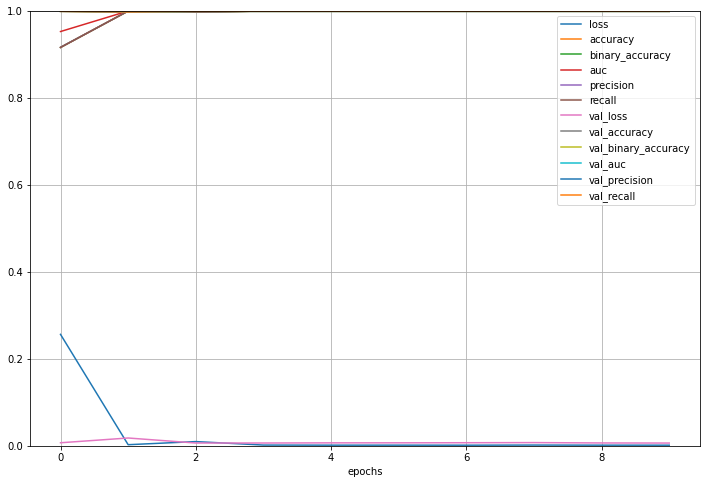

In [64]:
# graph of the training
pd.DataFrame(history.history).plot(figsize=(12, 8))
plt.grid(True)
plt.legend()
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.xlabel('epochs')
plt.show()
# plt.savefig('bilstm_all_metrics.png')

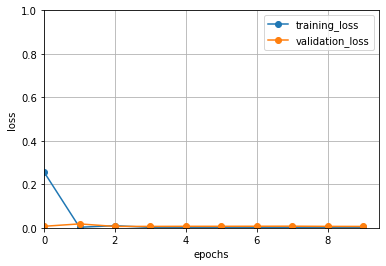

In [66]:
# graph of the training
plt.plot(history.epoch, history.history['loss'], '-o', label='training_loss')
plt.plot(history.epoch, history.history['val_loss'], '-o', label='validation_loss')
plt.legend()
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.grid(True)
plt.xlim(left=0)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()
# plt.savefig('bilstm_loss_metrics.png')

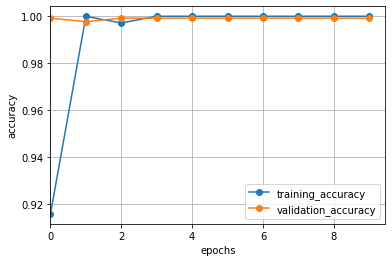

In [47]:
# graph of the training
plt.plot(history.epoch, history.history['accuracy'], '-o', label='training_accuracy')
plt.plot(history.epoch, history.history['val_accuracy'], '-o', label='validation_accuracy')
plt.grid(True)
plt.legend()
plt.xlim(left=0)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()
# plt.savefig('bilstm_accuracy_metrics.png')

In [48]:
# graph of the training
# plt.plot(history.epoch, history.history['accuracy'], '-o', label='training_accuracy')
# plt.plot(history.epoch, history.history['val_accuracy'], '-o', label='validation_accuracy')
# plt.grid(True)
# plt.legend()
# plt.xlim(left=0)
# plt.xlabel('epochs')
# plt.ylabel('accuracy')
# plt.show()

In [49]:
%%time
model.save("BiLSTM_10EP_" + datetime.now().strftime("%Y%m%d") + ".h5")

CPU times: user 177 ms, sys: 462 ms, total: 639 ms
Wall time: 617 ms


## Evaluate model with test data and view results

In [50]:
# Get Model Predictions for test data
# predicted_classes = model.predict_classes(X_test)
# print(classification_report(y_test, predicted_classes))

In [51]:
# Get Model Predictions for test data
predicted = model.predict(X_test)
predicted

array([[5.4806119e-06, 9.9999452e-01],
       [9.9790925e-01, 2.0906744e-03],
       [4.1673916e-06, 9.9999583e-01],
       ...,
       [3.8101598e-06, 9.9999619e-01],
       [4.0237501e-06, 9.9999595e-01],
       [9.9795461e-01, 2.0453404e-03]], dtype=float32)

In [52]:
predicted=np.argmax(predicted, axis=1)
print(predicted)

[1 0 1 ... 1 1 0]


In [53]:
y_test=np.argmax(y_test,axis=1)
print(y_test)

[1 0 1 ... 1 1 0]


In [54]:
report = classification_report(y_test, predicted)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       212
           1       1.00      1.00      1.00      1805

    accuracy                           1.00      2017
   macro avg       1.00      1.00      1.00      2017
weighted avg       1.00      1.00      1.00      2017



In [57]:
cm = confusion_matrix(y_test, predicted)
print(cm)

[[ 212    0]
 [   0 1805]]


In [58]:
test_loss, test_acc = model.evaluate(X_test)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

64/64 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - binary_accuracy: 0.0000e+00 - auc: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00


ValueError: too many values to unpack (expected 2)

In [ ]:
# predict crisp classes for test set
# yhat_classes = model.predict_classes(X_test, verbose=1)
# yhat_classes = model.predict(x = X_test) > 0.5, verbose=1).astype("int32")

In [59]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, predicted)
print('Testing Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, predicted,average='weighted')
print('Testing Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, predicted,average='weighted')
print('Testing Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, predicted,average='weighted')
print('Testing F1 score: %f' % f1)

Testing Accuracy: 1.000000
Testing Precision: 1.000000
Testing Recall: 1.000000
Testing F1 score: 1.000000


In [ ]:
# reduce to 1d array
#yhat_probs = yhat_probs[:, 0]
#yhat_classes = yhat_classes[:, 0]

In [60]:
#######################for testing####################
yhat_probs = model.predict(X_test, verbose=1)

64/64 [==============================] - 13s 196ms/step


In [61]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, yhat_probs)
print('Testing Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, yhat_probs,average='weighted')
print('Testing Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, yhat_probs,average='weighted')
print('Testing Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, yhat_probs,average='weighted')
print('Testing F1 score: %f' % f1)

ValueError: Classification metrics can't handle a mix of binary and continuous-multioutput targets

In [ ]:
# Setting up our results dataframe
df_results = pd.DataFrame(columns=['F1_score', 'Precision', 'Recall', 'Accuracy', 'Accuracy1', 'Training time'])

# append the results
df_results.loc['BiLSTM'] = [f1, precision, recall, accuracy, accuracy, run_time]
df_results

## Save performances result to SVC file


In [ ]:
# save the training results
df_results.to_csv("performances_BiLSTM_algorithm_" + datetime.now().strftime("%Y%m%d") + ".csv")

In [ ]:
# ls -l

## Evaluation of the model

In [ ]:
# %%time
# ##Evaluation of the model
# results = model.evaluate(X_test, 
#                y_test,
#               #  batch_size=8
#                )
# print("test loss, test acc:", results)

# Using the model to make predictions

In [ ]:
# %%time
# X_new = X_test[:10]
# y_proba = model.predict(X_new)
# y_proba.round(2)
# print("predictions shape:", y_proba.shape)

In [ ]:
# y_proba

In [ ]:
# cpu_model = get_model()
# cpu_model.load_weights('./DNN_TPU_1024.h5')
# cpu_predictions = cpu_model.predict(data)
# template = ('\nPrediction is "{}" ({:.1f}%), expected "{}"')
# for pred_dict, expec in zip(cpu_predictions, PREDICTION_OUTPUT_DATA):
#   class_index = np.argmax(pred_dict)
#   class_probability = np.max(pred_dict)
#   print(template.format(SPECIES[class_index], 100*class_probability, expec))